In [1]:
# Script to try out implementing tactile information as image
import glob
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import torch
import torch.nn as nn
import torchvision.transforms as T 

from abc import ABC
from copy import deepcopy
from torchvision.datasets.folder import default_loader as loader 
from torch.utils import data
from tqdm import tqdm
from omegaconf import DictConfig, OmegaConf

In [20]:
root = '/home/irmak/Workspace/Holo-Bot/extracted_data/logitech_mouse/demonstration_1'
with open(os.path.join(root, 'tactile_indices.pkl'), 'rb') as f:
    tactile_indices = pickle.load(f)
with h5py.File(os.path.join(root, 'touch_sensor_values.h5'), 'r') as f:
    tactile_values = f['sensor_values'][()]


print(tactile_values.shape)

(9571, 15, 16, 3)


In [21]:
class TactileImage:
    def __init__(
        self,
        tactile_value, # (15,16,3) will be the shape
        sensor_indices = [3, 7], # Index and middle tip for now
        size = (4, 8)
    ): 
        desired_tactile_values = tactile_value[sensor_indices]
        num_sensors = len(desired_tactile_values)

        # Reshape the tensor to an image according to the sensor_indices
        tactile_image = torch.FloatTensor(desired_tactile_values)
        tactile_image = tactile_image.reshape((num_sensors, size[0], int(size[1]/num_sensors), -1))
        tactile_image = torch.concat((tactile_image[0], tactile_image[1]), dim=1)
        self.tactile_image = torch.permute(tactile_image, (2,0,1))

        # Resize transform
        self.resize = T.Resize((size[1],size[1]))
        self.tactile_image = self.resize(self.tactile_image)

        # Set up the transforms
        # self.means, self.stds = self.calculate_mean_std(self.tactile_image)


    def calculate_mean_std(self): # This will be used for transforms
        means, stds = [0,0,0], [0,0,0]
        for channel_num in range(self.tactile_image.shape[0]):
            means[channel_num] = self.tactile_image[channel_num,:,:].mean()
            stds[channel_num] = self.tactile_image[channel_num,:,:].std()
        return means, stds

    def plot(self):
        # Map it to 0 and 1 - not super certain this is correct
        min, max = self.tactile_image.min(), self.tactile_image.max()
        img_range = max - min
        img = (self.tactile_image - min) / img_range
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    def apply_aug(self, augmentation):
        self.tactile_image = augmentation(self.tactile_image)

    def get_image(self):
        return self.tactile_image

In [22]:
def get_augmentations(img_means, img_stds):
    tactile_aug = T.Compose([
        T.RandomApply(
            nn.ModuleList([T.RandomResizedCrop((8,8), scale=(.8, 1))]),
            p = 0.5
        ), 
        T.RandomApply(
            nn.ModuleList([T.GaussianBlur((3, 3), (1.0, 2.0))]), 
            p = 0.5
        ),
        T.Normalize(
            mean = img_means, # NOTE: Wasn't this wrong?
            std = img_stds
        )
    ])
    return tactile_aug

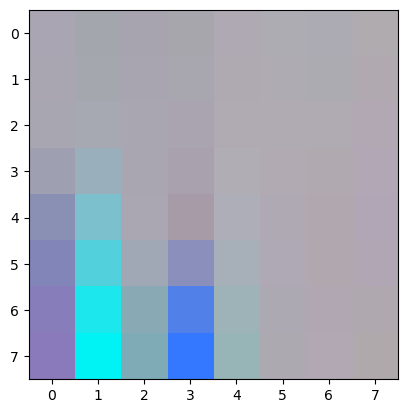

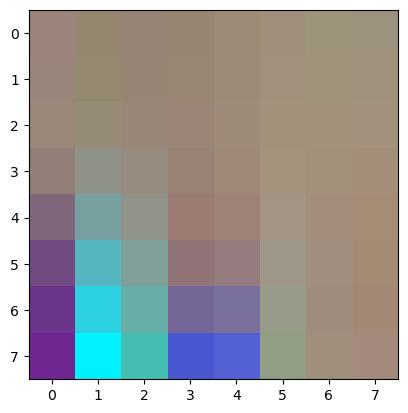

In [42]:
index = 4582
curr_tactile_value = tactile_values[index]
# print(tactile_values[1000][(3,7),:,:].shape)
img = TactileImage(tactile_value=tactile_values[index])
img.plot()
img_means, img_stds = img.calculate_mean_std()
tactile_aug = get_augmentations(img_means, img_stds)
img.apply_aug(tactile_aug)
img.plot()

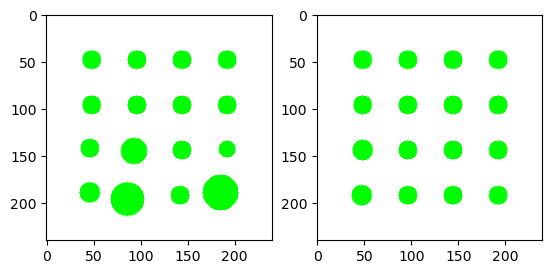

In [43]:
import cv2
import matplotlib.pyplot as plt

def plot_tactile_sensor(ax, sensor_values, use_img=False, img=None):
    # sensor_values: (16, 3) - 3 values for each tactile - x and y represents the position, z represents the pressure on the tactile point
    img_shape = (240, 240, 3) # For one sensor
    blank_image = np.ones(img_shape, np.uint8) * 255
    if use_img == False: 
        img = ax.imshow(blank_image.copy())

    # Set the coordinates for each circle
    tactile_coordinates = []
    for j in range(48, 192+1, 48): # Y
        for i in range(48, 192+1, 48): # X - It goes from top left to bottom right row first 
            tactile_coordinates.append([i,j])

    # Plot the circles 
    for i in range(sensor_values.shape[0]):
        center_coordinates = (
            tactile_coordinates[i][0] + int(sensor_values[i,0]/20), # NOTE: Change this
            tactile_coordinates[i][1] + int(sensor_values[i,1]/20)
        )
        radius = max(10 + int(sensor_values[i,2]/10), 2)
      
        if i == 0:
            frame_axis = cv2.circle(blank_image.copy(), center_coordinates, radius, color=(0,255,0), thickness=-1)
        else:
            frame_axis = cv2.circle(frame_axis.copy(), center_coordinates, radius, color=(0,255,0), thickness=-1)

    img.set_array(frame_axis)

    return img, frame_axis

fig, axs = plt.subplots(nrows=1, ncols=2)
plot_tactile_sensor(axs[0], curr_tactile_value[3,:,:])
plot_tactile_sensor(axs[1], curr_tactile_value[7,:,:])
plt.show()


In [19]:
# Create the encoder for this image
from tactile_learning.models.custom import PrintSize
class TactileImageEncoder(nn.Module):
    def __init__(
        self,
        in_channels,
        out_dim # Final dimension of the representation
    ):
        super().__init__()
        self.out_dim = out_dim
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels=64, kernel_size=2),
            nn.ReLU(),
            # PrintSize(),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=2),
            nn.ReLU(),
            # PrintSize(),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=2),
            nn.ReLU(),
            # PrintSize()
        )
        self.linear = nn.Linear(in_features=16*5*5, out_features=out_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.model(x)
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        x = self.linear(x)
        return self.relu(x)


In [17]:
encoder = TactileImageEncoder(3, 64)
tactile_img = img.get_image().unsqueeze(0)
out = encoder(tactile_img)
print(out.shape)

torch.Size([1, 64])


In [223]:
print(out)

tensor([[0.0068, 0.0000, 0.0000, 0.0000, 0.0000, 0.0303, 0.0020, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0376, 0.0635, 0.0000, 0.0280, 0.0000, 0.0000, 0.0000,
         0.0000, 0.1187, 0.0144, 0.0000, 0.0000, 0.0000, 0.0111, 0.0259, 0.0213,
         0.0776, 0.0152, 0.0227, 0.0000, 0.0528, 0.0000, 0.0000, 0.0860, 0.0000,
         0.0000, 0.0544, 0.0617, 0.0214, 0.0000, 0.0336, 0.0000, 0.0000, 0.0304,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0027, 0.0000, 0.0000, 0.0227, 0.0159,
         0.0000]], grad_fn=<ReluBackward0>)


In [224]:
# Dataset to get all tactile images from the given datapath
class TactileImageDataset(data.Dataset):
    def __init__(self):
        super().__init__()
        root = '/home/irmak/Workspace/Holo-Bot/extracted_data/logitech_mouse/demonstration_1'
        # with open(os.path.join(root, 'tactile_indices.pkl'), 'rb') as f:
        #     tactile_indices = pickle.load(f)
        with h5py.File(os.path.join(root, 'touch_sensor_values.h5'), 'r') as f:
            self.tactile_values = f['sensor_values'][()]

    def __len__(self):
        return len(self.tactile_values)

    def __getitem__(self, id):
        tactile_value = self.tactile_values[id]
        tactile_image = TactileImage(tactile_value)
        return tactile_image.get_image()

In [228]:
# Train with BYOL on this encoder
from tactile_learning.models.ssl_wrappers.byol import BYOL
from torch.optim import Adam
from torch.utils.data import DataLoader
augment_fn = get_augmentations(img_means, img_stds) # One augment_fn is enough (since it will be the same as augment2)
image_size = 8
learner = BYOL(
    net = TactileImageEncoder(3, 64), 
    image_size = image_size,
    augment_fn = augment_fn
)
optimizer = Adam(
    learner.parameters(),
    lr = 1e-2,
    weight_decay = 1e-5
)

dataset = TactileImageDataset()
dataloader = DataLoader(
    dataset, 
    batch_size = 32,
    shuffle = True,
    num_workers = 4,
    pin_memory = True,
)

batch = next(iter(dataloader))
print(batch.shape)


def train_one_epoch(earner, dataloader, optimizer):
    learner.train()
    total_train_loss = 0

    for idx, (input_images) in enumerate(tqdm(dataloader)):
        
        # input_data = torch.cat(input_images, dim = 1).to(configs.device)

        # print('input_images.shap: {}'.format(input_images.shape))
        loss = learner(input_images) 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        learner.update_moving_average()

        total_train_loss += loss.item()

    average_train_loss = total_train_loss / len(dataloader)
    return average_train_loss 

average_loss = train_one_epoch(learner, dataloader, optimizer)

torch.Size([32, 3, 8, 8])


100%|██████████| 300/300 [06:01<00:00,  1.21s/it]
